In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_pickle('data.pkl')
data

,ID,Query,Time,Rank,URL,Domain,Hour,DidClick
0,479,family guy,2006-03-01 16:01:20,NaN,NaN,NaN,16,False
1,479,also sprach zarathustra,2006-03-02 14:48:55,NaN,NaN,NaN,14,False
2,479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com,familyguyfiles,22,True
3,479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com,movieweb,22,True
4,479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com,imdb,22,True
...,...,...,...,...,...,...,...,...
3614501,24969423,my space. com,2006-05-31 19:03:32,2.0,http://music.myspace.com,myspace,19,True
3614502,24969423,my space.com,2006-05-31 19:12:00,NaN,NaN,NaN,19,False
3614503,24969423,my space.com 3131560415,2006-05-31 19:12:25,NaN,NaN,NaN,19,False
3614504,24969423,jennifer craford my space.com,2006-05-31 19:15:02,NaN,NaN,NaN,19,False


In [3]:
user = pd.read_pickle('user.pkl')
user

,Queries,Hour,Success,Length,Rank,LogQueries,LogLength,LogRank,CatSuccess
28495,269,15.386617,0.505576,3.249071,3.852941,2.429752,0.511759,0.585792,0.5
66674,417,17.597122,0.757794,5.371703,10.750000,2.620136,0.730112,1.031408,0.8
88575,322,15.046584,0.583851,2.363354,2.643617,2.507856,0.373529,0.422199,0.5
90662,27,15.333333,0.407407,2.000000,1.181818,1.431364,0.301030,0.072551,0.5
110786,66,17.681818,0.757576,1.090909,1.380000,1.819544,0.037789,0.139879,0.8
...,...,...,...,...,...,...,...,...,...
24881102,3,18.000000,0.333333,2.000000,1.000000,0.477121,0.301030,0.000000,0.1
24887358,3,19.333333,0.666667,1.000000,1.000000,0.477121,0.000000,0.000000,0.5
24896608,19,18.052632,0.368421,1.105263,2.285714,1.278754,0.043466,0.359022,0.5
24903847,3,23.000000,0.666667,2.333333,1.000000,0.477121,0.367977,0.000000,0.5


**a) Given a user’s activity, predict the likelihood of the user clicking on a search result.**

Use a subsample of the data to build the model. Again, focus on users who clicked on something at least once since this simplifies the analysis.

Furthermore, considering there is a time-element to the data and that we might want to use this to predict the future, ideally we want to separate training and validation sets by time. Due to limited time I'm just going to split based on the order the data is in, and then if I have time I'll come back and split more on time.

If I'm lucky there'll be a natural splitting of the data based on time already. Let's check that.

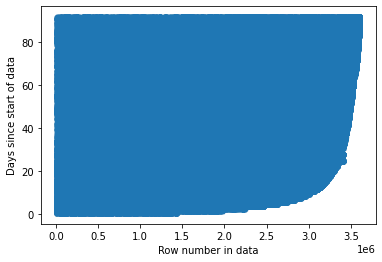

In [4]:
ax = pd.Series(
    (pd.to_numeric((data['Time'] - data['Time'].min()))/1e9/60/60/24).values,
    index=range(len(data))
).plot(style='.',alpha=0.1)

ax.set_xlabel('Row number in data')
ax.set_ylabel('Days since start of data');

If there was natural splitting in time in the data we'd expect to get more of a line with a positive gradient. In the figure above however, the data is distributed between 0 and 90 from the beginining, so I can conclude that there is no natural organisation by time in the data. So I would need to do any time-based splitting myself.

Next, do some feature engineering and split into train and test sets.

In [5]:
data['DidClick'] = data['DidClick'].replace({False: 0, True: 1})

In [6]:
userids = np.unique(data[pd.notnull(data['URL'])]['ID'])
print(len(userids))
n_train = 1000
n_valid = 1000
userids_train = userids[:n_train]
userids_valid = userids[n_train:n_train+n_valid]

52330


While I'm developing a model it's helpful to keep the numbers small, so I limit it to 1000 users for both training and validation sets. This should be large enough to be representative. As before, I will forego statistical checks about this due to considerations for time.

In [7]:
data_train = data.set_index('ID').loc[userids_train]
data_valid = data.set_index('ID').loc[userids_valid]

In [8]:
from datetime import timedelta as td
deltas = []
for id in userids_train:
    data_user = data[data['ID'] == id]
    dt = data_user['Time'].iloc[1:].reset_index(drop=True) - data_user['Time'].iloc[:-1].reset_index(drop=True)
    deltas = deltas + [td(1,0,0)*7] + list(dt)
data_train['Delta'] = deltas
data_train['Delta'] = pd.to_numeric(data_train['Delta']/1e9)
data_train['LogDelta'] = np.log10(data_train['Delta'] + 1)

deltas = []
for id in userids_valid:
    data_user = data[data['ID'] == id]
    dt = data_user['Time'].iloc[1:].reset_index(drop=True) - data_user['Time'].iloc[:-1].reset_index(drop=True)
    deltas = deltas + [td(1,0,0)*7] + list(dt)
data_valid['Delta'] = deltas
data_valid['Delta'] = pd.to_numeric(data_valid['Delta']/1e9)
data_valid['LogDelta'] = np.log10(data_valid['Delta'] + 1)

# Todo: Refactor this to be more succinct

If we want to consider the history of the user as an indicator of whether they will be successful in their search, the simplest metric would be to see if they have searched in the past. Eventually we might want to narrow this down to whether they searched for a similar term before, but for now we just see how long ago they made a query.

In [9]:
data_train

,Query,Time,Rank,URL,Domain,Hour,DidClick,Delta,LogDelta
ID,,,,,,,,,
479,family guy,2006-03-01 16:01:20,NaN,NaN,NaN,16,0,604800,5.781613
479,also sprach zarathustra,2006-03-02 14:48:55,NaN,NaN,NaN,14,0,82055,4.914110
479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com,familyguyfiles,22,1,114531,5.058927
479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com,movieweb,22,1,296,2.472756
479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com,imdb,22,1,0,0.000000
...,...,...,...,...,...,...,...,...,...
401432,sears.com,2006-05-24 16:26:36,NaN,NaN,NaN,16,0,168033,5.225397
401432,sars.com,2006-05-24 16:37:28,NaN,NaN,NaN,16,0,652,2.814913
401432,sears.com,2006-05-24 16:37:41,NaN,NaN,NaN,16,0,13,1.146128


<AxesSubplot:xlabel='DidClick', ylabel='LogDelta'>

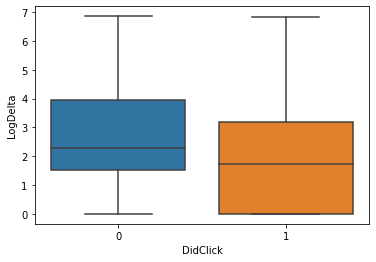

In [10]:
sns.boxplot(x='DidClick', y='LogDelta', data=data_train)

Users who clicked on a result generally made a previous search more recently than those who did not. This suggests that recent user search activity is indicitive of future successful searches.

First we need to set up a basic benchmark. If we had absolutely no information, what is the probability that a user clicks on a query?

This can be modelled as a Bernoulli distribution. This is somewhat overkill for a simple question, but I was curious about the tightness of the distribution.

In [11]:
import pymc3 as pm

with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    click = pm.Bernoulli('click', p=theta, observed=data_train['DidClick'][:10000])
    trace = pm.sample(2000)

/var/folders/33/177sh4qs67bf8wzmdtqvp6sm0000gn/T/ipykernel_27732/2858842842.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8882228020675448, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/james/Documents/Job_applications/2021/C1X/venv-c1x/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

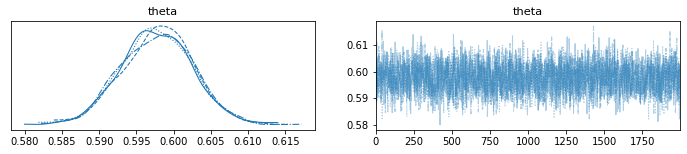

In [12]:
import arviz as az
az.plot_trace(trace)

Theta is very tightly defined around 0.6, suggesting a user is slightly more likely to click when making a query, than not.

Any model that we make needs to beat this benchmark; ie, we need to be correct more than 60% of the time.

The point estimate from the full training data gives a similar suggested benchmark.

In [13]:
len(data_valid[data_valid['DidClick'] == 1]) / len(data_valid)

0.5889961718685948

In [14]:
data_train[['LogDelta','Hour','DidClick']]

,LogDelta,Hour,DidClick
ID,,,
479,5.781613,16,0
479,4.914110,14,0
479,5.058927,22,1
479,2.472756,22,1
479,0.000000,22,1
...,...,...,...
401432,5.225397,16,0
401432,2.814913,16,0
401432,1.146128,16,0


In [15]:
cols = ['LogDelta','Hour']

from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(data_train[cols])
data_train_ss = pd.DataFrame(
    ss.transform(data_train[cols]),
    index = data_train[cols].index,
    columns = data_train[cols].columns,
)
data_train_ss = data_train[cols]

In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(data_train_ss.values, data_train['DidClick'].values)

[Text(0.5, 0.8333333333333334, 'X[0] <= 0.151\ngini = 0.485\nsamples = 169955\nvalue = [70337, 99618]'),
 Text(0.25, 0.5, 'X[1] <= 8.5\ngini = 0.03\nsamples = 38319\nvalue = [574, 37745]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.039\nsamples = 6918\nvalue = [136, 6782]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.028\nsamples = 31401\nvalue = [438, 30963]'),
 Text(0.75, 0.5, 'X[0] <= 1.866\ngini = 0.498\nsamples = 131636\nvalue = [69763, 61873]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.458\nsamples = 40797\nvalue = [26338, 14459]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.499\nsamples = 90839\nvalue = [43425, 47414]')]

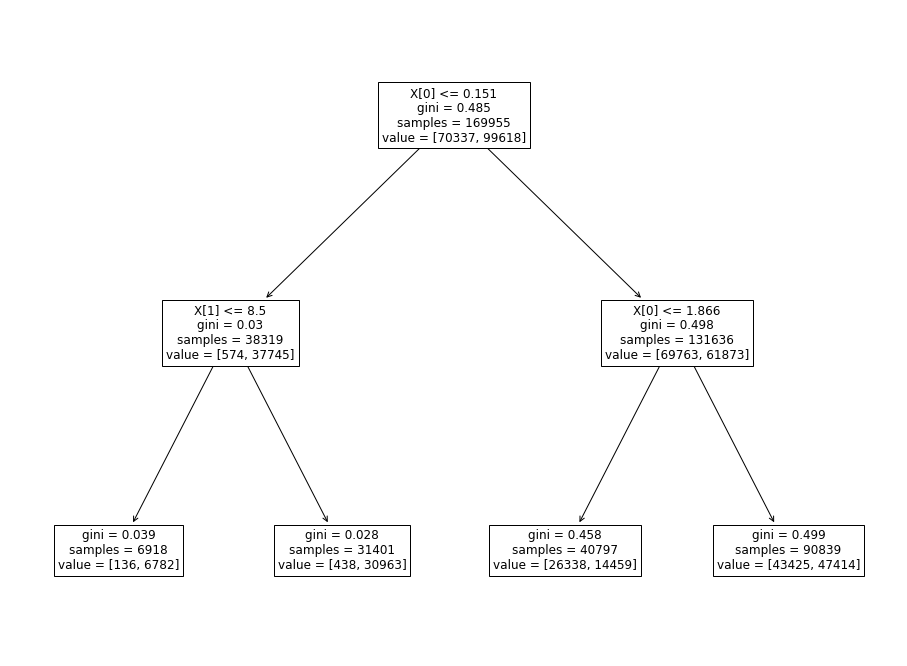

In [17]:
fig, ax = plt.subplots(figsize=(16,12))
tree.plot_tree(clf, fontsize=12, ax=ax)

In [18]:
data_valid[cols]

,LogDelta,Hour
ID,,
401487,5.781613,21
401487,4.888309,18
401487,2.260071,18
401487,2.071882,18
401487,0.000000,18
...,...,...
813808,1.740363,11
813808,3.430075,12
813808,1.518514,12


In [19]:
_ = clf.predict(data_valid[cols])
_

/Users/james/Documents/Job_applications/2021/C1X/venv-c1x/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 0, 1, 1])

In [20]:
prediction = data_valid[['DidClick']].copy()
prediction = prediction.rename(columns={'DidClick': 'Actual'})
prediction['Predicted'] = _
prediction

,Actual,Predicted
ID,,
401487,0,1
401487,0,1
401487,0,1
401487,1,1
401487,1,1
...,...,...
813808,0,0
813808,0,1
813808,1,0


In [21]:
from sklearn.metrics import confusion_matrix as cm
pred = cm(prediction['Actual'], prediction['Predicted'])/len(prediction)
print(pred)
print(pred[0][0] + pred[1][1])

[[0.15742008 0.25358375]
 [0.08507029 0.50392588]]
0.6613459634340924


This simple model improves on the naive model by around 6%.

The model seems to largely be predicting clicks, so most clicks are well predicted, but no-clicks are poorly predicted. Try modifying the depth hyperparameter to see if this can be improved.

In [22]:
from sklearn import tree

logout = []
for maxdepth in range(1,15):
    clf = tree.DecisionTreeClassifier(max_depth=maxdepth)
    clf = clf.fit(data_train_ss.values, data_train['DidClick'].values)
    cmat = cm(
        data_valid['DidClick'],
        clf.predict(data_valid[cols].values)
        )/len(prediction)
    logout.append([maxdepth, cmat[0][0], cmat[1][1]])

logout = pd.DataFrame(logout,columns=['Depth',0,1])
logout = logout.set_index('Depth')
logout['Accuracy'] = logout[0] + logout[1]

<AxesSubplot:xlabel='Depth'>

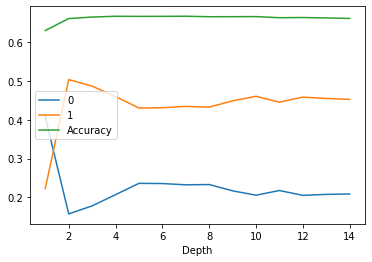

In [23]:
logout.plot()

In [24]:
logout

,0,1,Accuracy
Depth,,,
1,0.407327,0.223104,0.630431
2,0.157420,0.503926,0.661346
3,0.178200,0.487037,0.665237
4,0.207066,0.460158,0.667224
5,0.236253,0.430655,0.666908
6,0.235742,0.431273,0.667016
7,0.232488,0.434799,0.667287
8,0.233175,0.432850,0.666025
9,0.217030,0.449102,0.666133


There is no improvement beyond 6% with more than 2 splits. This is likely due to the limited number of dimensions.

So the model had a positive contribution to improving the prediction of whether a user would like on a result based on their past interaction with the site.

There are two ways that the current approach could be improved upon to yield a better increase in predictive ability.

1. I engineered a single feature. With more time it would be better to engineer more features. In particular, I have not considered the nature of the text, and so it would be good to incorporate some text processing (full words? Searched the same query in the past?).
2. The decision tree is a simple model. I chose this model because I have so few features a complicated model would be unlikely to do much better and I always try to start simply (occam's razor). It would be interesting to experiment with more complex models after progressing further with (1).